# Mount drive and installation setup


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%cd CubiCasa5k


/content/drive/MyDrive/CubiCasa5k


In [ ]:
%ls

 create_lmdb.py                       floortrans/                   requirements.txt
 data/                                LICENSE                       runs_cubi/
'Difference in Room Annotation.pdf'   model_best_val_loss_var.pkl   samples.ipynb
 Dockerfile                           predicted/                    train.py
 eval.py                              README.md                     val.txt


In [ ]:

!pip install tensorboardX
!pip install tqdm
!pip install lmdb
!pip install svgpathtools
!pip install torch torchvision
!pip install scikit-image matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.7 MB/s eta 0:00:00


# import libraries


In [ ]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from google.colab import files
import cv2
from PIL import Image
import io
from torchvision import transforms
from floortrans.models import get_model
from floortrans.loaders import RotateNTurns
from floortrans.plotting import discrete_cmap, segmentation_plot, polygons_to_image, draw_junction_from_dict
from floortrans.post_prosessing import split_prediction,get_polygons


#  Import custom modules and setup classes

In [ ]:
# Import your floortrans modules
from floortrans.models import get_model
from floortrans.post_prosessing import split_prediction

# Define classes
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet",
                "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

# Set parameters
n_classes = 44
split = [21, 12, 11]

# Model setup

In [ ]:
# Setup Model
model = get_model('hg_furukawa_original', 51)

# Modify model layers
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)

#This is a transposed convolution (also known as deconvolution) that increases the spatial dimensions by 4x.
# It's used at the end of the network to restore the output to the original image size.
# Recover spatial resolution lost during downsampling (maxpooling)


#run this to use cpu
# checkpoint = torch.load('model_best_val_loss_var.pkl', map_location=torch.device('cpu'))

# Load checkpoint (adjust path to your model file location)
checkpoint = torch.load('model_best_val_loss_var.pkl') # uncomment if gpu available
model.load_state_dict(checkpoint['model_state'])


# Set model to evaluation mode and move to GPU
model.eval()
model.cuda() # remove if you want to use CPU
print("Model loaded.")

/content/drive/MyDrive/CubiCasa5k/floortrans/models/hg_furukawa_original.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('floortrans/m

Model loaded.


# Upload Image

In [ ]:
# Upload your floorplan image
import os
from google.colab import files
uploaded = files.upload()
for filename in uploaded:
    os.rename(filename, f'predicted/{filename}')

Saving F1_original.png to F1_original.png


In [ ]:
# Get the filename of the uploaded image
img = next(iter(uploaded))
image_path = f'predicted/{img}'
print(f"Processing image: {image_path}")

Processing image: predicted/F1_original.png


In [ ]:
image = Image.open(image_path).convert('RGB')

# Convert to numpy array
np_img = np.array(image)

# Display image
plt.figure(figsize=(10,10))
plt.title('Uploaded Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()
# print(np_img)

NameError: name 'Image' is not defined

# Single Image Prediction Function Test Time Augmentation (TTA)

---



In [ ]:
def get_predictions_with_tta(image_path, model, n_classes=44):

    # Initialize rotation utility
    rot = RotateNTurns()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        # transforms.Resize((512, 512)), # # Resize to fixed dimensions
        transforms.ToTensor(), # Convert to tensor [0,1]
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                           std=[0.5, 0.5, 0.5])   # Normalize to [-1,1]
    ])

    # Process image and gpu processes
    image_tensor = transform(image).unsqueeze(0) # Add batch dimension as  Neural networks are designed to process multiple samples simultaneously
    #Even for a single image, models expect this batch dimension # Models expect input in shape: (batch_size, channels, height, width)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda() #move to gpu if its available

    # Get image dimensions
    height, width = image_tensor.shape[2:]

    # Define rotations for test-time augmentation
    #(0,0): No rotation
    #(1,-1): 90° clockwise + rotate back counterclockwise
    #(2,2): 180° + rotate back
    # (-1,1): 90° counterclockwise + rotate back clockwise
    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)

    # Initialize prediction tensor
    prediction = torch.zeros([pred_count, n_classes, height, width])

    # Get predictions with different rotations


    #For each rotation:

    # Rotates input image
    # Gets model prediction
    # Rotates prediction back
    # Fixes heatmap orientations
    # Ensures consistent size
    # Stores prediction
    with torch.no_grad():
        for i, (forward, back) in enumerate(rotations):
            # Rotate image
            rot_image = rot(image_tensor, 'tensor', forward)

            # Get prediction
            pred = model(rot_image)

            # Rotate prediction back
            pred = rot(pred, 'tensor', back)

            # Fix heatmaps
            pred = rot(pred, 'points', back)

            # Ensure correct size
            pred = F.interpolate(pred, size=(height, width),
                               mode='bilinear', align_corners=True)

            # Add to predictions
            prediction[i] = pred[0]

    # Average predictions
    prediction = torch.mean(prediction, 0, True)

    print("predictions", prediction.shape)


    # Process room predictions

    # Process room predictions (channels 21-33)
    rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()  # # Each pixel now has probabilities for 12 room types
    rooms_pred = np.argmax(rooms_pred, axis=0)

    # Process icon predictions
    # Process icon predictions (channels 33-44)
    icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
    icons_pred = np.argmax(icons_pred, axis=0)


    return {
        'original_image': image,
        'rooms_pred': rooms_pred,
        'icons_pred': icons_pred,
        'raw_prediction': prediction,
        "original_size": (height,width),
    }


# Process Image

In [ ]:
# Process and visualize
predictions = get_predictions_with_tta(image_path, model)

predictions torch.Size([1, 44, 629, 525])


In [ ]:
print(predictions['rooms_pred'].shape)
print(predictions['icons_pred'].shape)

(629, 525)
(629, 525)


# visualize image

In [ ]:
def visualize_tta_predictions(predictions, room_classes, icon_classes):
    """
    Visualize predictions from test-time augmentation
    """
    try:
        # Try to initialize colormaps, catch and ignore if already registered
        try:
            discrete_cmap()
        except ValueError:
            pass  # Colormaps already registered

        n_rooms = len(room_classes)
        n_icons = len(icon_classes)

        # 1. Room Predictions
        plt.figure(figsize=(12, 12))
        ax = plt.subplot(1, 1, 1)
        ax.axis('off')
        rseg = ax.imshow(predictions['rooms_pred'], cmap='rooms',
                         vmin=0, vmax=n_rooms-0.1)
        cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5,
                           fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(room_classes, fontsize=20)
        plt.title('Room Predictions ', fontsize=20)
        plt.show()

        # 2. Icon Predictions
        plt.figure(figsize=(12, 12))
        ax = plt.subplot(1, 1, 1)
        ax.axis('off')
        iseg = ax.imshow(predictions['icons_pred'], cmap='icons',
                         vmin=0, vmax=n_icons-0.1)
        cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5,
                           fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(icon_classes, fontsize=20)
        plt.title('Icon Predictions ', fontsize=20)
        plt.show()



    except Exception as e:
        print(f"Error during visualization: {str(e)}")
        # You might want to add additional error handling here

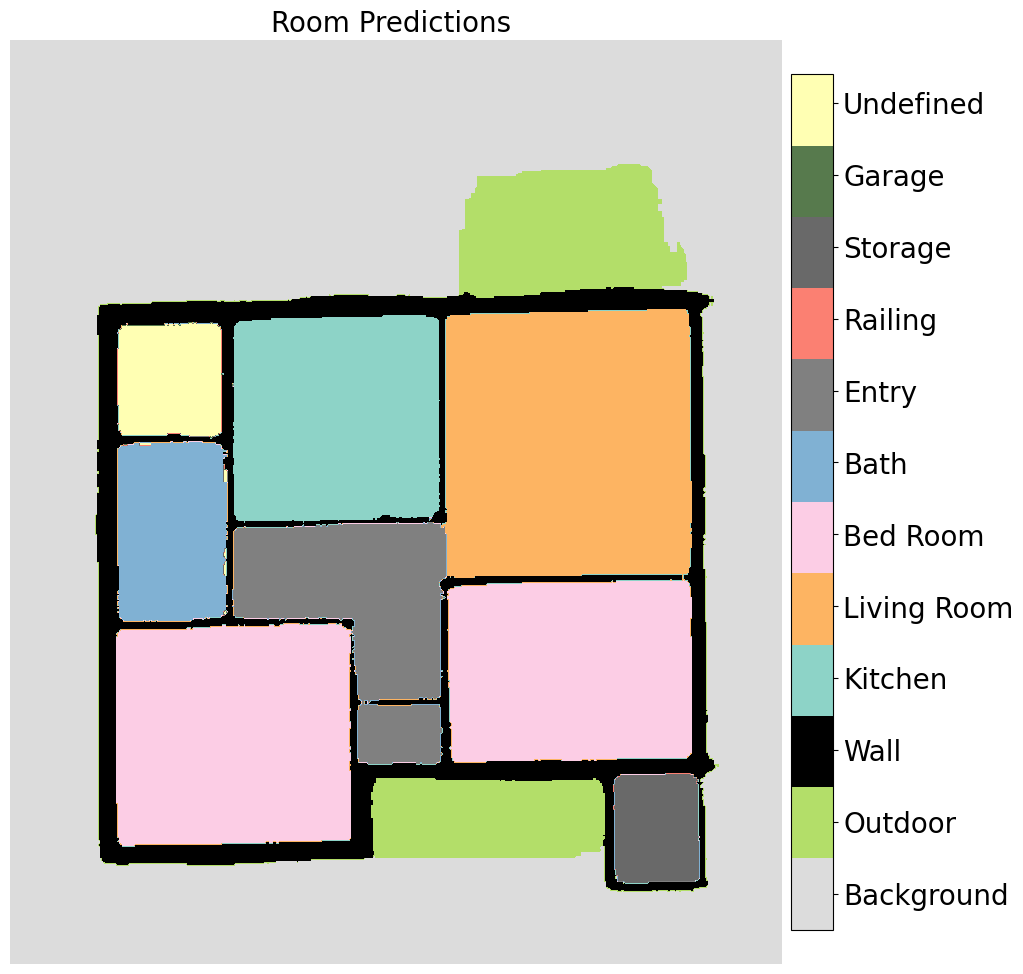

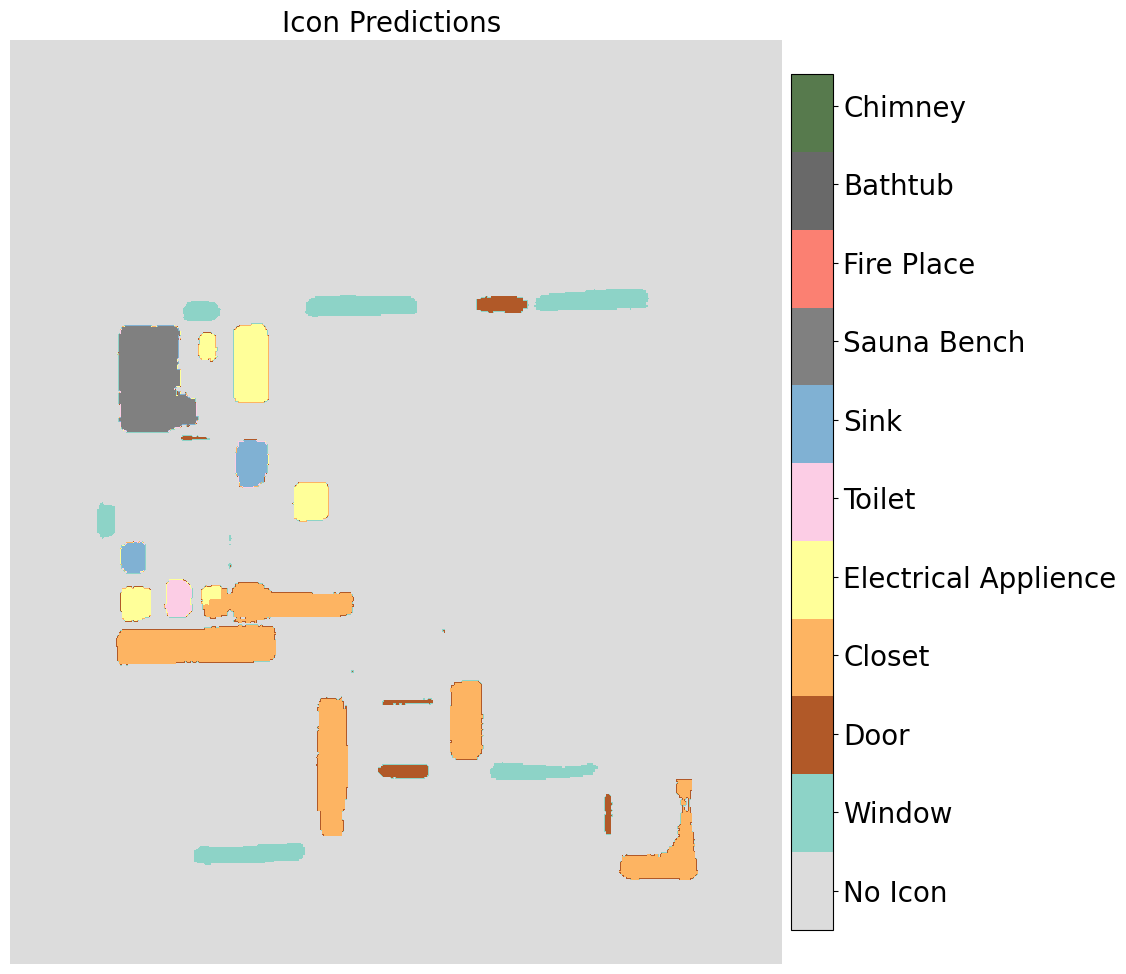

In [ ]:
visualize_tta_predictions(predictions, room_classes, icon_classes)

# post-processing  polygons


In [ ]:
#Monkey patch for the scipy version
import numpy as np
import scipy.stats as stats
from collections import namedtuple

# Create a mode result type that matches scipy's return format
ModeResult = namedtuple('ModeResult', ['mode', 'count'])

def get_mode(data):
    if len(data) == 0:
        # Return in the expected format
        return ModeResult(np.array([5]), np.array([1]))

    values, counts = np.unique(data, return_counts=True)
    mode_idx = np.argmax(counts)
    # Return in the expected format
    return ModeResult(np.array([values[mode_idx]]), np.array([counts[mode_idx]]))

# Replace mode function
stats.mode = get_mode

In [ ]:
from scipy import ndimage

def process_and_visualize_polygons(predictions, room_classes, icon_classes):
    """
    Process predictions into polygons and visualize results using the original image dimensions
    """
    try:
        # Get original image dimensions from predictions
        height, width = predictions['original_size']
        img_size = (height, width)


        # Convert predictions to the format expected by get_polygons
        raw_pred = predictions['raw_prediction']

        # Ensure raw_prediction is in the correct format
        if len(raw_pred.shape) == 3:
            raw_pred = raw_pred.unsqueeze(0)

        # Split parameters for different prediction types
        split = [21, 12, 11]  # heatmaps, rooms, icons

        # Split predictions into components
        heatmaps, rooms, icons = split_prediction(raw_pred, img_size, split)

        print("Split shapes:")
        print("Heatmaps shape:", heatmaps.shape)
        print("Rooms shape:", rooms.shape)
        print("Icons shape:", icons.shape)

        # Generate polygons from predictions
        polygons, types, room_polygons, room_types = get_polygons(
            (heatmaps, rooms, icons),
            threshold=0.2,
            all_opening_types=[1, 2]  # window and door types
        )

        print(f"Number of polygons: {len(polygons)}")
        print(f"Number of room polygons: {len(room_polygons)}")

        # Generate segmentation images from polygons
        pol_room_seg, pol_icon_seg = polygons_to_image(
            polygons, types,
            room_polygons, room_types,
            height, width
        )

        # Create figure for original image
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.title('Original Image', fontsize=15)
        plt.axis('off')
        plt.imshow(predictions['original_image'])

        # Visualize room polygons
        plt.subplot(1,3,2)
        plt.title('Room Polygons', fontsize=15)
        plt.axis('off')
        rseg = plt.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=len(room_classes)-0.1)
        cbar = plt.colorbar(rseg, ticks=np.arange(len(room_classes)) + 0.5, fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(room_classes, fontsize=8)

        # Visualize icon polygons
        plt.subplot(1,3,3)
        plt.title('Icon Polygons', fontsize=15)
        plt.axis('off')
        iseg = plt.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=len(icon_classes)-0.1)
        cbar = plt.colorbar(iseg, ticks=np.arange(len(icon_classes)) + 0.5, fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(icon_classes, fontsize=8)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
  # Combined Room and Icon Plot
        plt.subplot(1, 3, 2)
        plt.title('Combined Room and Icon Layout', fontsize=15)
        plt.axis('off')

        # Plot rooms first
        plt.imshow(pol_room_seg, cmap='rooms', alpha=0.7,
                  vmin=0, vmax=len(room_classes)-0.1)

        # Overlay icons with transparency
        icon_mask = pol_icon_seg > 0
        plt.imshow(np.ma.masked_where(~icon_mask, pol_icon_seg),
                  cmap='icons', alpha=0.5,
                  vmin=0, vmax=len(icon_classes)-0.1)
        plt.tight_layout()
        plt.show()

        # Show larger individual plots
        # Room polygons
        plt.figure(figsize=(12,12))
        ax = plt.subplot(1, 1, 1)
        ax.axis('off')
        rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=len(room_classes)-0.1)
        # Find connected components and label centers
        for room_idx in range(1, len(room_classes)):  # Skip background (0)
            room_mask = (pol_room_seg == room_idx)
            if room_mask.any():  # If room exists
                # Find connected components
                labeled_array, num_features = ndimage.label(room_mask)
                # For each connected component
                for label in range(1, num_features + 1):
                    # Get center of mass for this component
                    component = (labeled_array == label)
                    cy, cx = ndimage.center_of_mass(component)
                    # Add text at center
                    plt.text(cx, cy, room_classes[room_idx],
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=8)
        cbar = plt.colorbar(rseg, ticks=np.arange(len(room_classes)) + 0.5, fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(room_classes, fontsize=20)
        plt.title('Room Polygons', fontsize=20)
        plt.tight_layout()
        plt.show()

        # Icon polygons
        plt.figure(figsize=(12,12))
        ax = plt.subplot(1, 1, 1)
        ax.axis('off')
        iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=len(icon_classes)-0.1)
        cbar = plt.colorbar(iseg, ticks=np.arange(len(icon_classes)) + 0.5, fraction=0.046, pad=0.01)
        cbar.ax.set_yticklabels(icon_classes, fontsize=20)
        plt.title('Icon Polygons', fontsize=20)
        plt.tight_layout()
        plt.show()

        return {
            'pol_room_seg': pol_room_seg,
            'pol_icon_seg': pol_icon_seg,
            'polygons': polygons,
            'types': types,
            'room_polygons': room_polygons,
            'room_types': room_types,
            'img_size' : img_size
        }

    except Exception as e:
        print(f"Error during post-processing: {str(e)}")
        import traceback
        traceback.print_exc()  # This will print the full error traceback
        return None

Split shapes:
Heatmaps shape: (21, 629, 525)
Rooms shape: (12, 629, 525)
Icons shape: (11, 629, 525)
Number of polygons: 61
Number of room polygons: 11


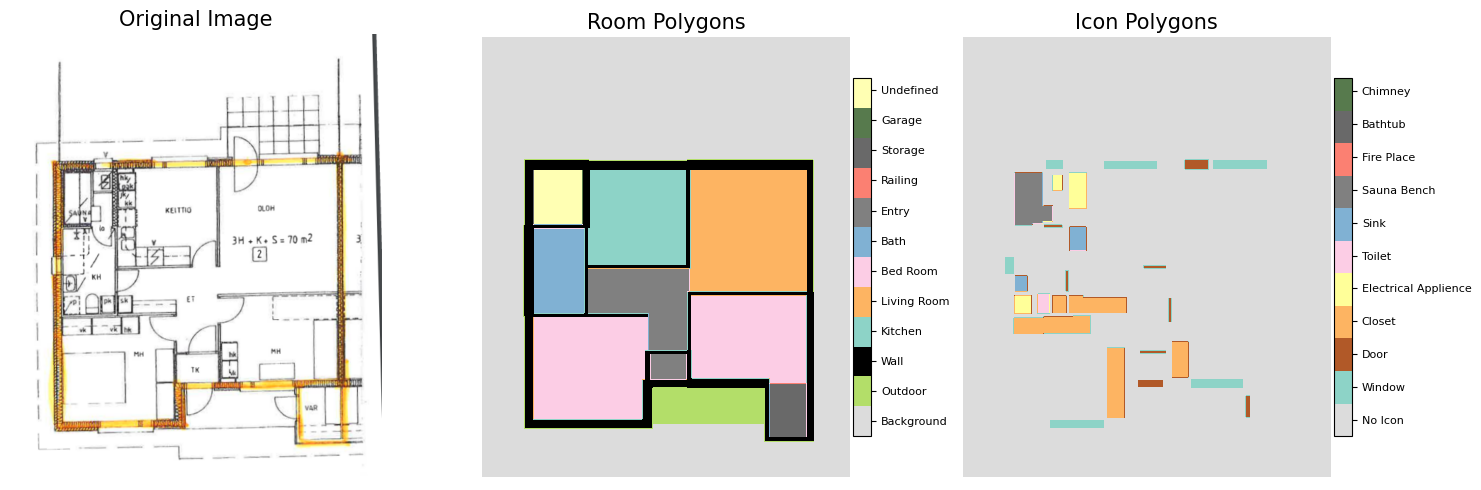

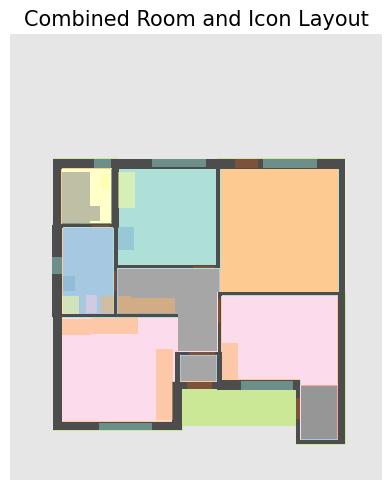

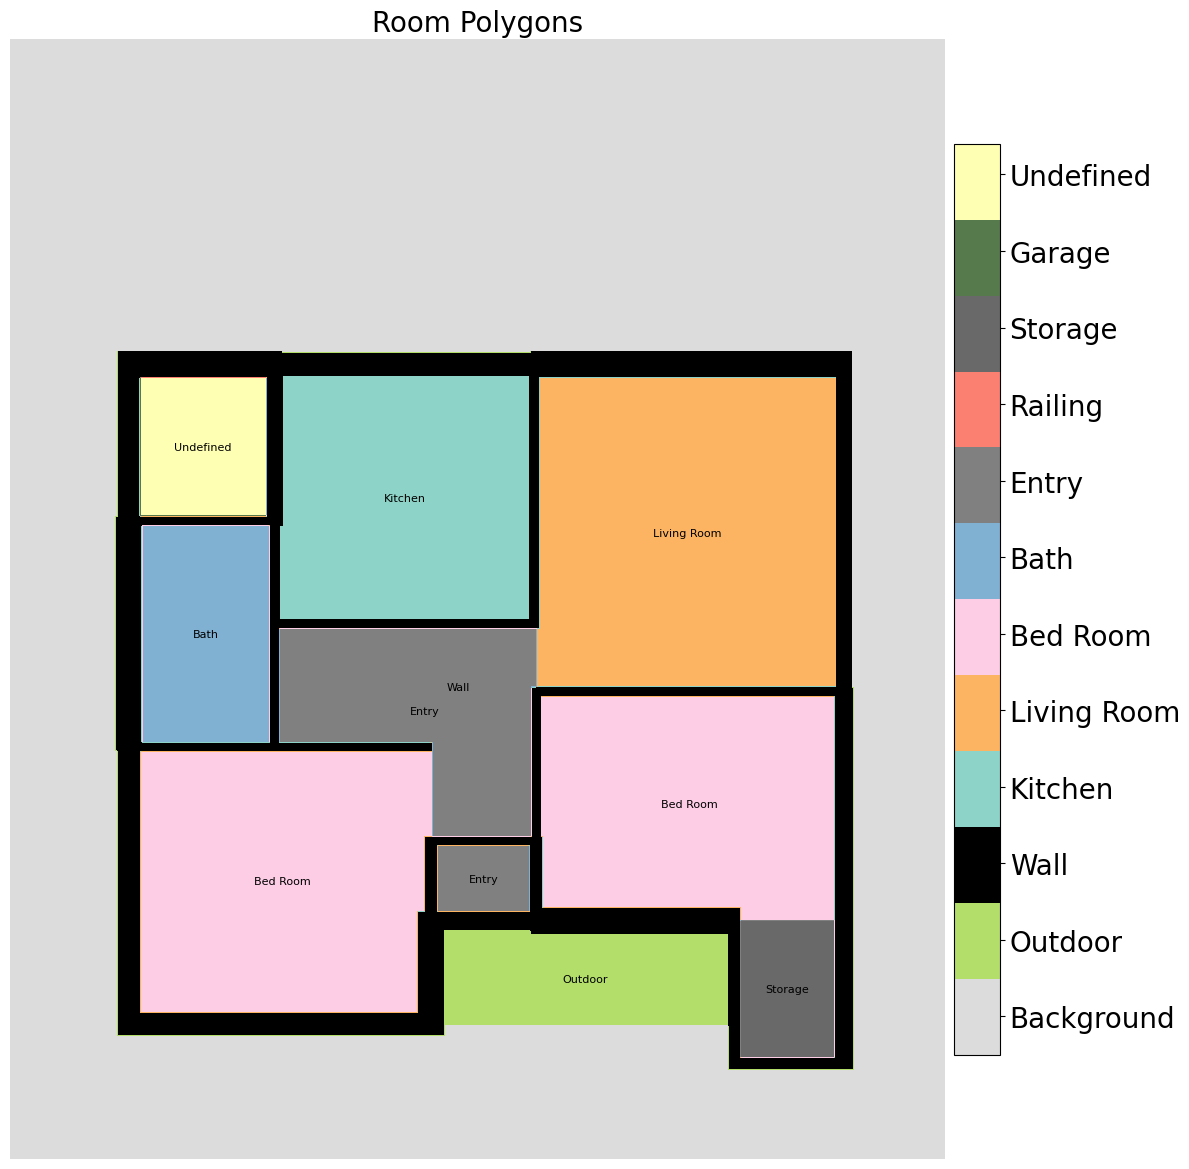

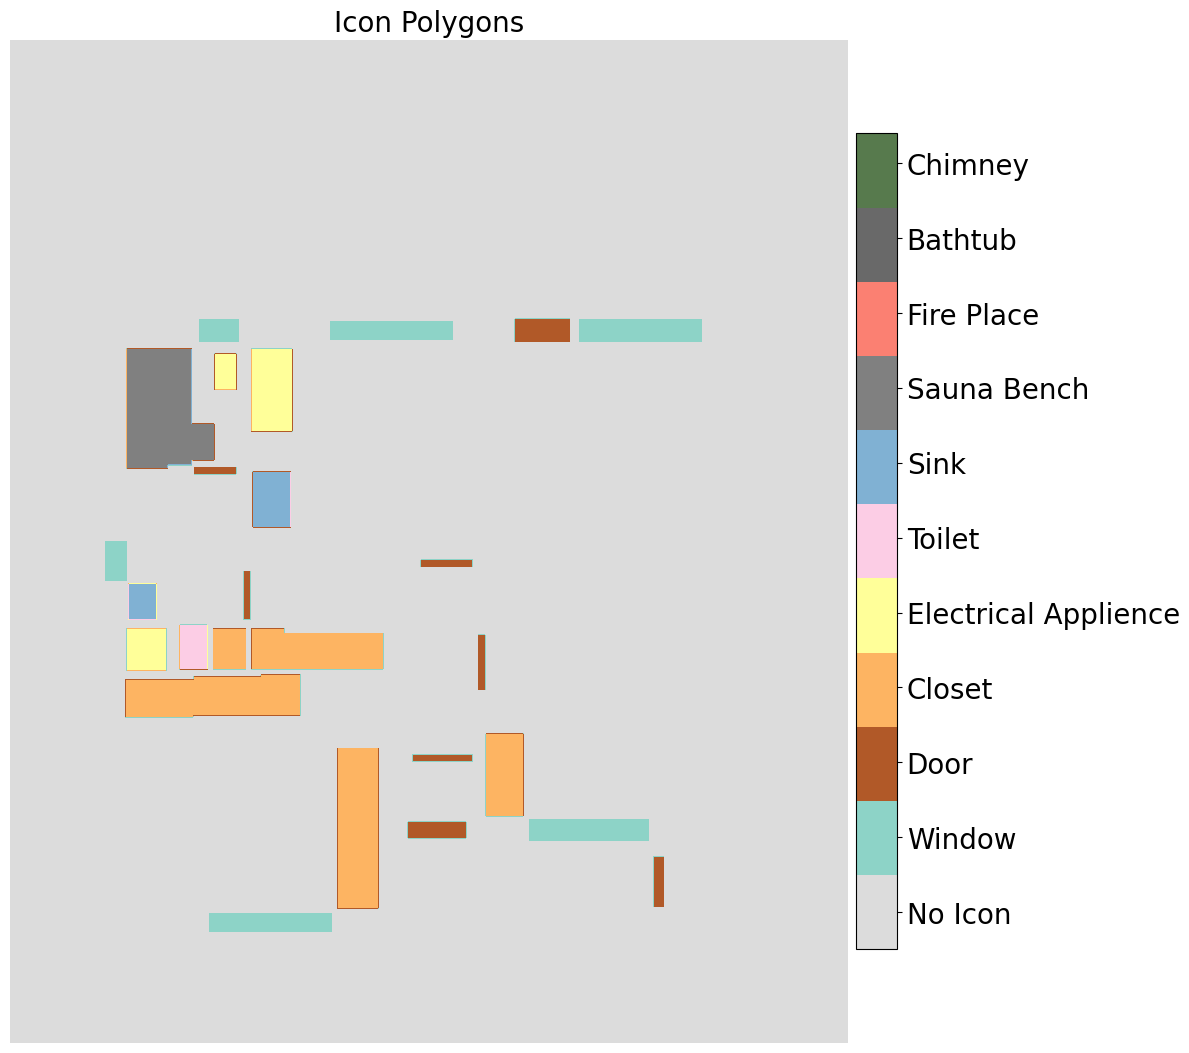

In [ ]:
polygon_results = process_and_visualize_polygons(predictions, room_classes, icon_classes)

# Scalin dimensions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from shapely.geometry import Polygon
import cv2

# Updated standards with exact room type matching
STANDARD_AREAS = {
    'Bath': 3.0,           # Will match "Bath 1", "Bath 2", etc.
    'Bed Room': 7.0,       # Will match "Bed Room 1", "Bed Room 2", etc.
    'Entry': 4.0,          # Will match "Entry 1", "Entry 2", etc.
    'Kitchen': 4.2,
    'Living Room': 13.5,
    'Storage': 3.0,        # Will match "Storage 1", "Storage 2", etc.
    'Garage': 18.0
}

def get_polygon_from_mask(mask):
    """Extract polygon coordinates from binary mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8),
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # Get largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    # Simplify polygon
    epsilon = 0.01 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    return Polygon(approx.squeeze())

def get_base_room_name(room_class):
    """Extract base room name by removing numbers."""
    parts = room_class.split()
    base_name = ' '.join(part for part in parts if not any(c.isdigit() for c in part))
    return base_name.strip()

def get_standard_area(room_class):
    """Get the standard area with proper room name matching."""
    base_name = get_base_room_name(room_class)
    return STANDARD_AREAS.get(base_name, 0.0)

def calculate_room_metrics(pol_room_seg, room_classes, scale_meters_per_pixel):
    """Calculate metrics for each room instance."""
    room_metrics = []
    excluded_classes = {'Wall', 'Railing', 'Background', 'Outdoor'}

    for room_idx, room_class in enumerate(room_classes):
        if room_class in excluded_classes:
            continue

        room_mask = (pol_room_seg == room_idx)
        labeled_array, num_features = ndimage.label(room_mask)

        room_instances = []
        for feature_idx in range(1, num_features + 1):
            component = (labeled_array == feature_idx)
            polygon = get_polygon_from_mask(component)

            if polygon:
                area = polygon.area * (scale_meters_per_pixel ** 2)
                bounds = polygon.bounds
                width = (bounds[2] - bounds[0]) * scale_meters_per_pixel
                height = (bounds[3] - bounds[1]) * scale_meters_per_pixel
                centroid = polygon.centroid

                standard_area = get_standard_area(room_class)
                if standard_area > 0:
                    status = 'Pass' if area >= standard_area else 'Fail'
                else:
                    status = 'Pass'  # For undefined areas (0.0)

                room_instances.append({
                    'room_class': room_class,
                    'area': area,
                    'width': width,
                    'height': height,
                    'standard_area': standard_area,
                    'status': status,
                    'centroid': centroid,
                    'component': component
                })

        if room_instances:
            room_instances.sort(key=lambda x: x['area'], reverse=True)
            for idx, room in enumerate(room_instances, 1):
                room['instance'] = idx
                room_metrics.append(room)

    return room_metrics

def visualize_room_polygons_lb(pol_room_seg, room_classes, img_size, scale_meters_per_pixel=None):
    """Visualize room polygons with analysis table."""
    plt.close('all')

    # Calculate scale if not provided using room size method
    if scale_meters_per_pixel is None:
        room_areas_px = []
        for room_idx in range(len(room_classes)):
            room_mask = (pol_room_seg == room_idx)
            if np.any(room_mask):
                polygon = get_polygon_from_mask(room_mask)
                if polygon:
                    room_areas_px.append(polygon.area)

        if room_areas_px:
            avg_room_area_px = np.median(room_areas_px)
            avg_room_area_m = 14  # average room area in square meters
            scale_meters_per_pixel = np.sqrt(avg_room_area_m / avg_room_area_px)
        else:
            scale_meters_per_pixel = 0.05  # fallback value

        print(f"Calculated scale: {scale_meters_per_pixel:.4f} meters per pixel")

    # Create figure with subfigures
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

    # Floorplan subplot
    ax_plan = fig.add_subplot(gs[0])
    ax_plan.set_title('Floor Plan with Room Dimensions', fontsize=15)
    ax_plan.axis('off')

    # Display segmentation map
    cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))
    custom_cmap = plt.cm.colors.ListedColormap(cmap)
    rseg = ax_plan.imshow(pol_room_seg, cmap=custom_cmap, vmin=0, vmax=len(room_classes)-0.1)

    # Calculate room metrics
    room_metrics = calculate_room_metrics(pol_room_seg, room_classes, scale_meters_per_pixel)

    # Plot room labels and dimensions
    for metrics in room_metrics:
        room_label = (f"{metrics['room_class']} {metrics['instance']}"
                     if len([r for r in room_metrics if r['room_class'] == metrics['room_class']]) > 1
                     else metrics['room_class'])

        centroid = metrics['centroid']
        plt.text(centroid.x, centroid.y,
                f"{room_label}\n"
                f"{metrics['width']:.1f}m × {metrics['height']:.1f}m\n"
                f"Area: {metrics['area']:.1f}m²",
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

    # Add colorbar
    cbar = fig.colorbar(rseg, ax=ax_plan, ticks=np.arange(len(room_classes)) + 0.5,
                       fraction=0.046, pad=0.01)
    cbar.ax.set_yticklabels(room_classes, fontsize=8)

    # Analysis table subplot
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    ax_table.set_title('Room Analysis', fontsize=15)

    # Prepare table data
    table_data = [['Room', 'Area (m²)', 'Standard (m²)', 'Status']]
    sorted_metrics = sorted(room_metrics, key=lambda x: (x['room_class'], x['instance']))

    for metrics in sorted_metrics:
        room_name = (f"{metrics['room_class']} {metrics['instance']}"
                    if len([r for r in room_metrics if r['room_class'] == metrics['room_class']]) > 1
                    else metrics['room_class'])
        table_data.append([
            room_name,
            f"{metrics['area']:.1f}",
            f"{metrics['standard_area']:.1f}",
            metrics['status']
        ])

    # Create table
    table = ax_table.table(cellText=table_data,
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.35, 0.22, 0.22, 0.21])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Color code status cells
    for idx in range(1, len(table_data)):
        status = table_data[idx][3]
        cell = table._cells[(idx, 3)]
        if status == 'Pass':
            cell.set_facecolor('#90EE90')  # light green
        else:
            cell.set_facecolor('#FFB6C1')  # light red

    # Style header row
    for i in range(4):
        table._cells[(0, i)].set_facecolor('#4682B4')  # steel blue
        table._cells[(0, i)].set_text_props(color='white')

    plt.tight_layout()
    return fig



Calculated scale: 0.0301 meters per pixel


<ipython-input-20-b5f06a64cefe>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))


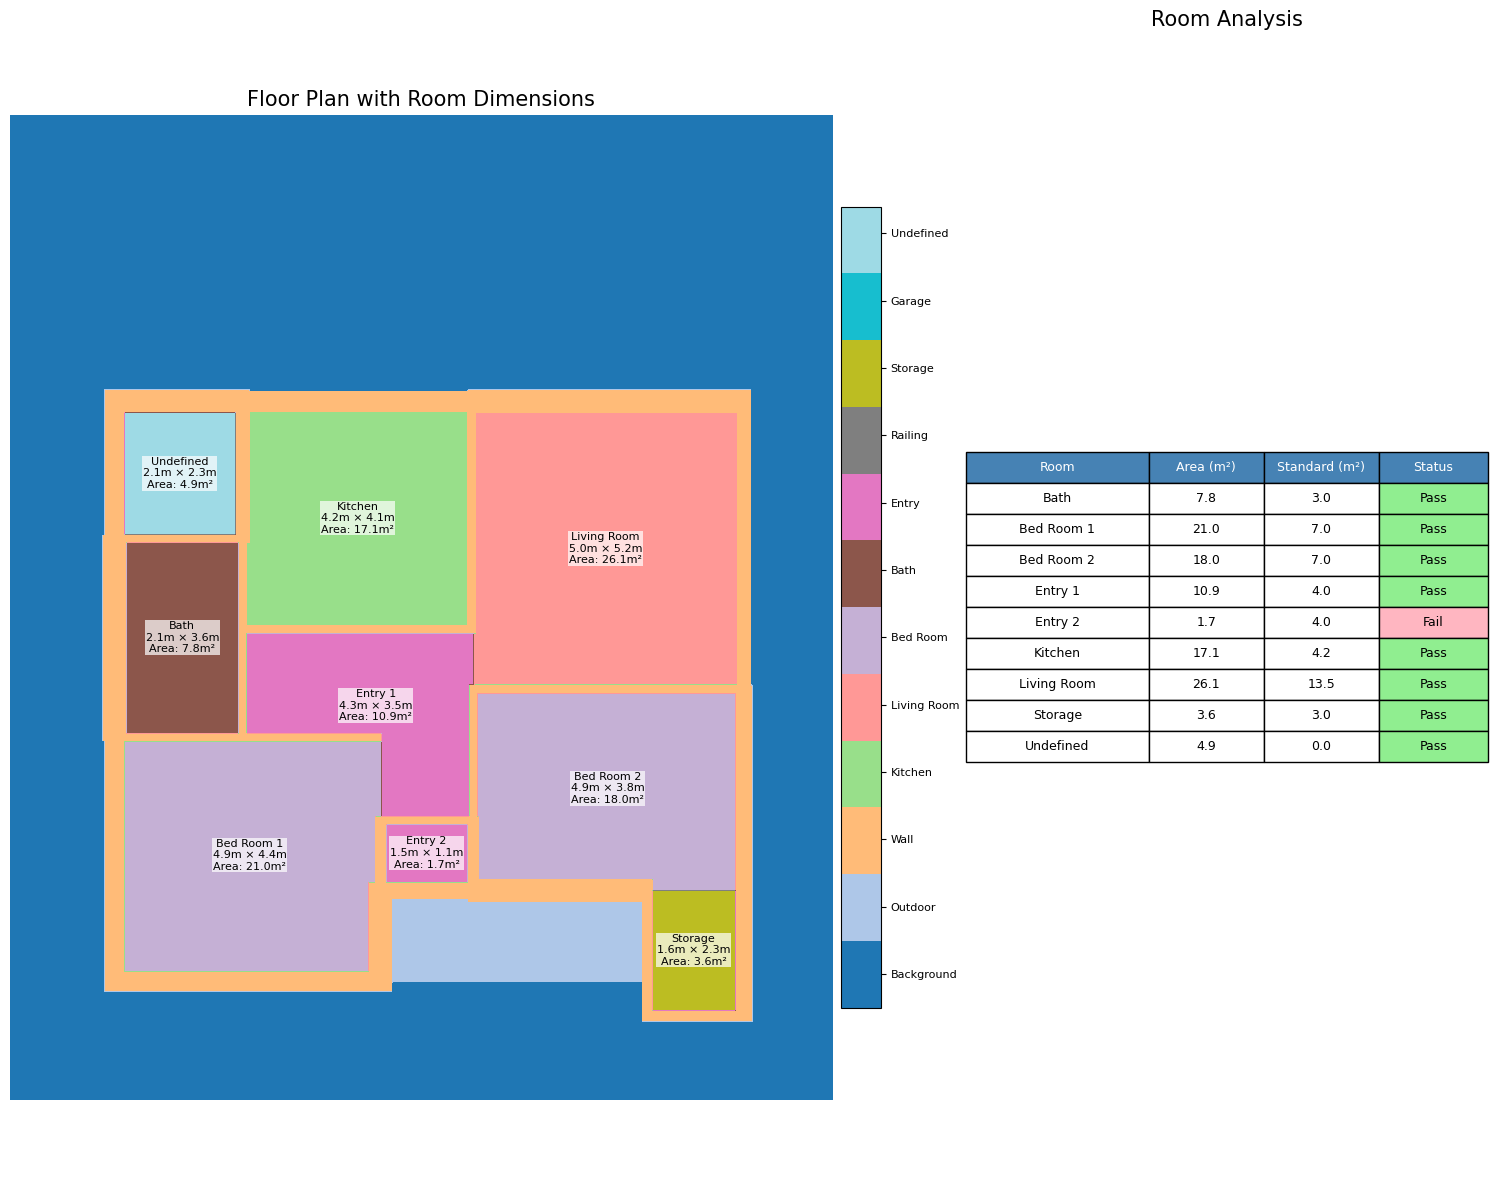

In [ ]:
fig = visualize_room_polygons_lb(polygon_results['pol_room_seg'], room_classes, polygon_results['img_size'])
plt.show()

# Scaling door size


In [ ]:
def get_door_width_scale(pol_icon_seg, icon_classes):
    """
    Calculate scale using standard door width (30 inches = 762mm)

    Args:
        pol_icon_seg: Icon segmentation array
        icon_classes: List of icon class names
    Returns:
        scale_meters_per_pixel: Calculated scale based on door width
    """
    STANDARD_DOOR_WIDTH_M = 0.762  # 30 inches = 762mm

    # Get door index from icon classes
    door_idx = icon_classes.index("Door")

    print("door index", door_idx)

    # Create mask for doors
    door_mask = (pol_icon_seg == door_idx)

    if not np.any(door_mask):
        print("No doors detected")
        return None

    # Label individual doors
    labeled_array, num_features = ndimage.label(door_mask)

    door_widths = []

    # Process each door
    for feature_idx in range(1, num_features + 1):
        component = (labeled_array == feature_idx)
        polygon = get_polygon_from_mask(component)

        if polygon:
            # Get bounds
            bounds = polygon.bounds
            width_px = bounds[2] - bounds[0]
            door_widths.append(width_px)

    print(door_widths)
    if door_widths:
        # Use average door width
        avg_width_px = np.mean(door_widths)
        # Calculate scale
        scale = STANDARD_DOOR_WIDTH_M / avg_width_px

        print(f"Found {len(door_widths)} door(s)")
        print(f"Average door width: {avg_width_px:.1f} pixels")
        print(f"Scale: {scale:.6f} meters/pixel")
        print(f"Resolution: {1/scale:.1f} pixels/meter")

        return scale

    return None

In [ ]:
door_scale = get_door_width_scale(
    polygon_results['pol_icon_seg'],
    icon_classes
)

door index 2
[34.0, 26.0, 32.0, 4.0, 4.0, 37.0, 36.0, 6.0]
Found 8 door(s)
Average door width: 22.4 pixels
Scale: 0.034056 meters/pixel
Resolution: 29.4 pixels/meter


<ipython-input-20-b5f06a64cefe>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))


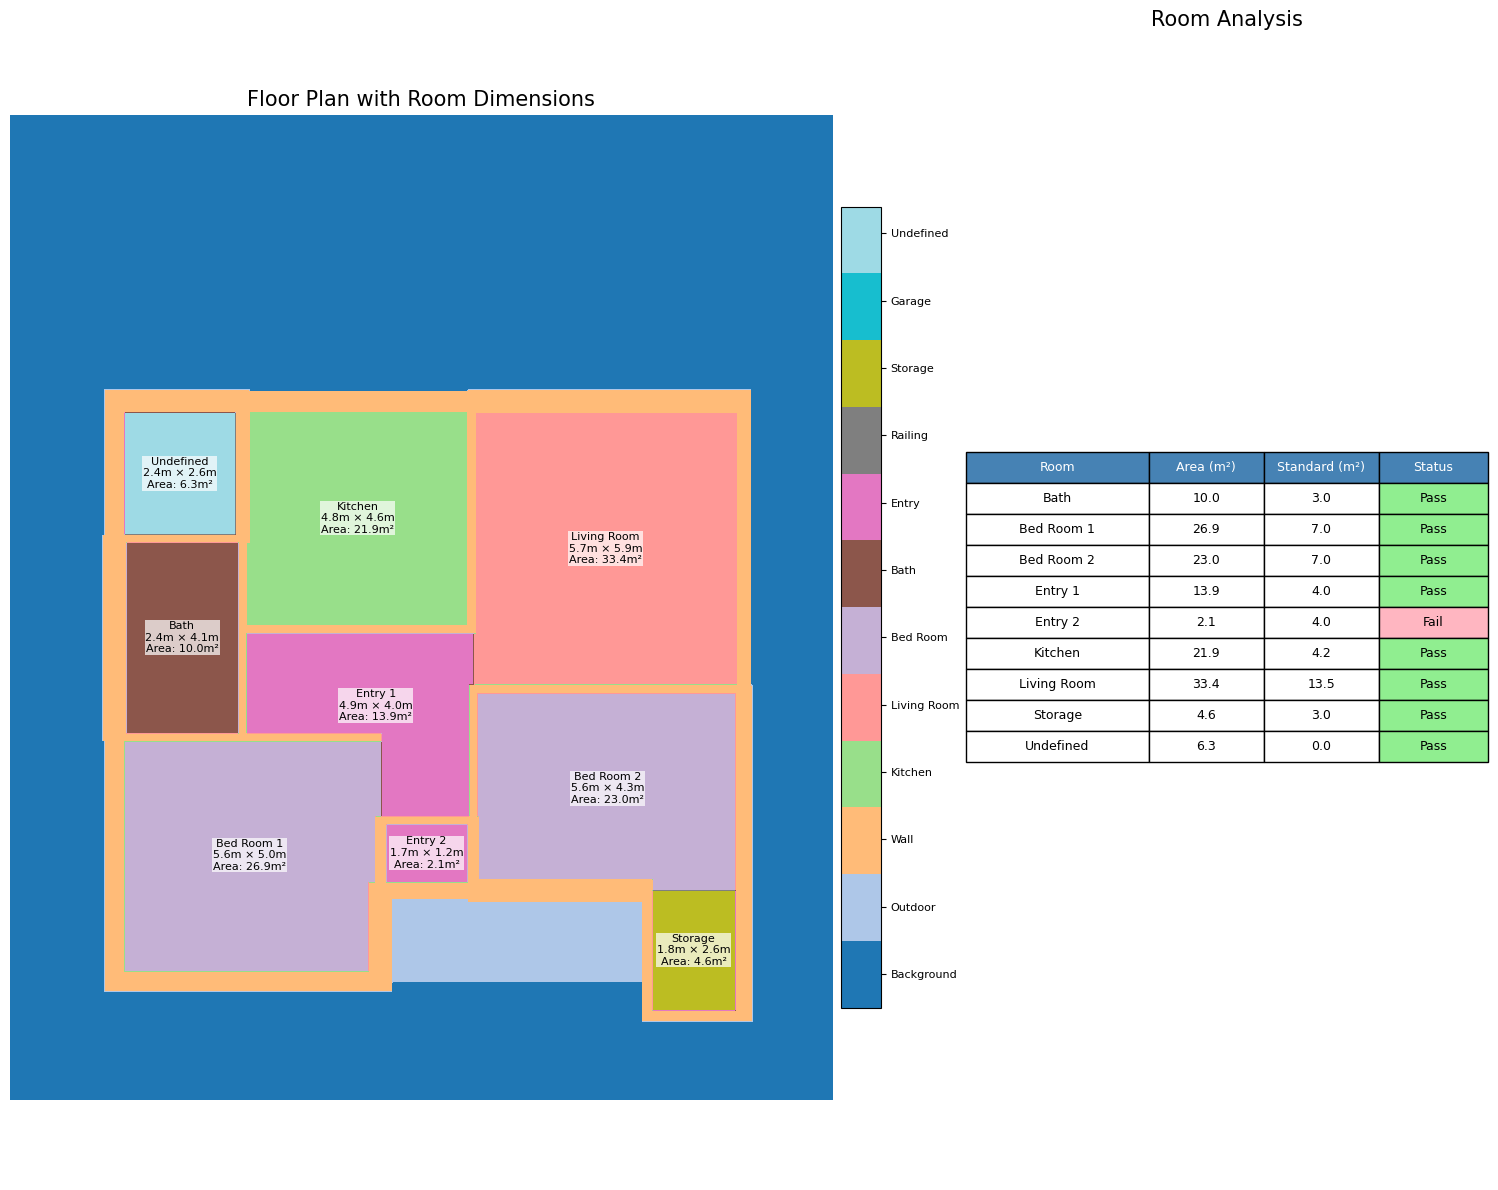

In [ ]:
fig = visualize_room_polygons_lb(polygon_results['pol_room_seg'], room_classes, polygon_results['img_size'], scale_meters_per_pixel=door_scale)
plt.show()

# rooms with closet

In [ ]:
import numpy as np
from scipy import ndimage
from typing import Dict, List, Tuple

def find_rooms_with_closets(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str]
) -> Dict[int, List[Tuple[float, float]]]:
    """
    Identifies bedrooms that contain closet icons and their locations.

    Args:
        pol_room_seg: Room segmentation array
        pol_icon_seg: Icon segmentation array
        room_classes: List of room type labels
        icon_classes: List of icon type labels

    Returns:
        Dictionary mapping bedroom indices to lists of closet centroid coordinates
    """
    # Find bedroom index in room classes
    bedroom_indices = [i for i, name in enumerate(room_classes)
                      if 'bed' in name.lower() or 'bedroom' in name.lower()]

    # Find closet index in icon classes
    closet_indices = [i for i, name in enumerate(icon_classes)
                     if 'closet' in name.lower()]

    rooms_with_closets = {}

    # For each bedroom index
    for bedroom_idx in bedroom_indices:
        # Create mask for this bedroom
        bedroom_mask = (pol_room_seg == bedroom_idx)

        # Skip if no such bedroom found
        if not np.any(bedroom_mask):
            continue

        # For each closet type
        closet_locations = []
        for closet_idx in closet_indices:
            # Create mask for this closet type
            closet_mask = (pol_icon_seg == closet_idx)

            # Find where closets overlap with this bedroom
            overlap = bedroom_mask & closet_mask

            if np.any(overlap):
                # Find all distinct closet components
                labeled_closets, num_closets = ndimage.label(overlap)

                # Get centroid for each closet
                for i in range(1, num_closets + 1):
                    closet_component = (labeled_closets == i)
                    cy, cx = ndimage.center_of_mass(closet_component)
                    closet_locations.append((cx, cy))

        # If closets were found in this bedroom, add to results
        if closet_locations:
            rooms_with_closets[bedroom_idx] = closet_locations

    return rooms_with_closets

def visualize_rooms_with_closets(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str],
    rooms_with_closets: Dict[int, List[Tuple[float, float]]]
) -> None:

    plt.figure(figsize=(12, 12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')

    # Show room segmentation
    cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))
    custom_cmap = plt.cm.colors.ListedColormap(cmap)
    plt.imshow(pol_room_seg, cmap=custom_cmap)

    # Overlay icon segmentation with transparency
    icon_mask = pol_icon_seg > 0
    plt.imshow(np.ma.masked_where(~icon_mask, pol_icon_seg),
              cmap='Set3', alpha=0.5)

    # Mark closet locations
    for room_idx, closet_locs in rooms_with_closets.items():
        room_name = room_classes[room_idx]
        for cx, cy in closet_locs:
            plt.plot(cx, cy, 'r*', markersize=15)
            plt.text(cx + 10, cy + 10,
                    f'Closet in {room_name}',
                    color='red',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7))

    plt.title('Bedrooms with Closets', fontsize=15)
    plt.tight_layout()
    plt.show()



In [ ]:
rooms_with_closets = find_rooms_with_closets(
    polygon_results['pol_room_seg'],
    polygon_results['pol_icon_seg'],
    room_classes,
    icon_classes
)
print(rooms_with_closets)

{5: [(127.0, 411.88532110091745), (309.8709677419355, 460.2903225806452), (216.97535771065182, 492.99443561208267)]}


<ipython-input-26-d8527f1fa231>:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))


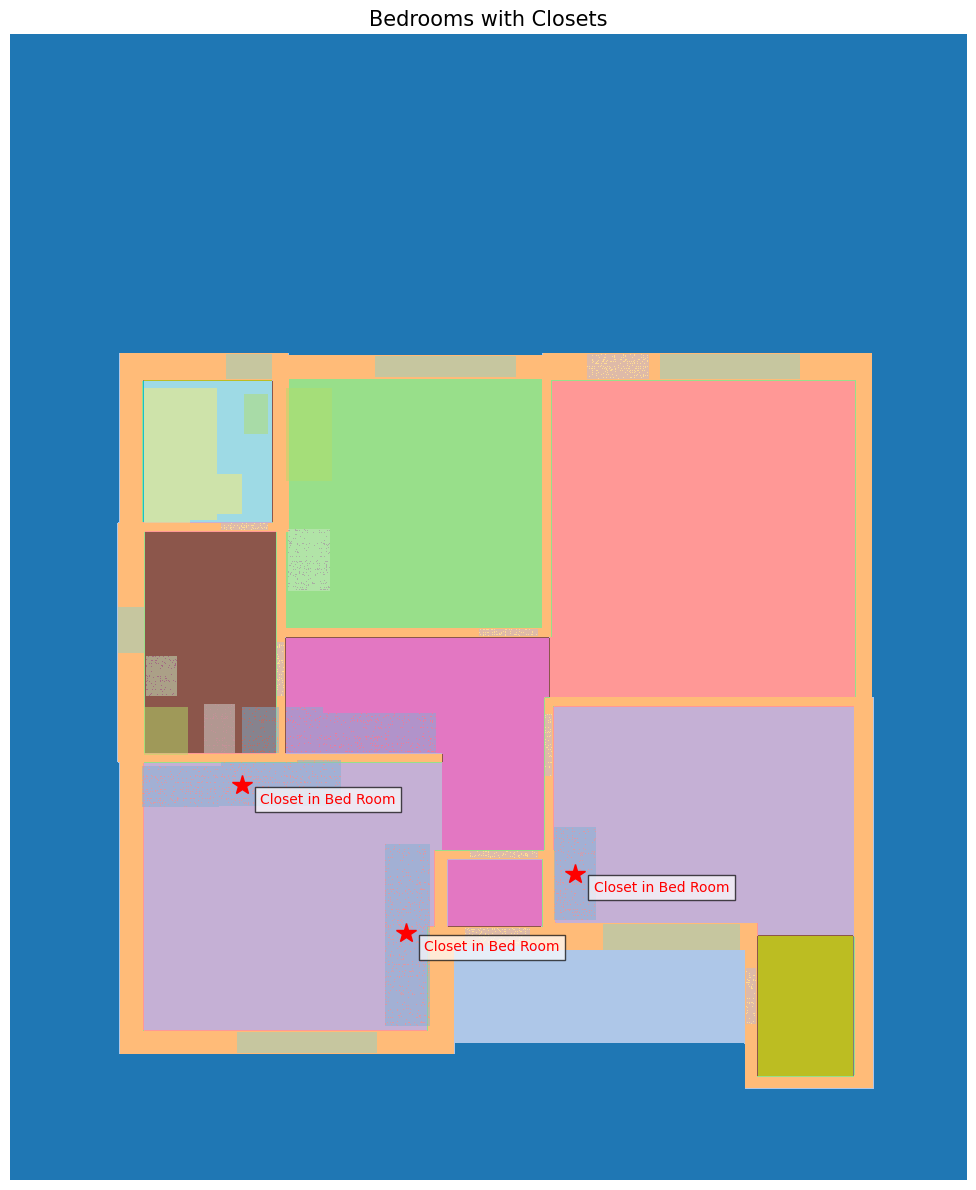

In [ ]:
visualize_rooms_with_closets(
    polygon_results['pol_room_seg'],
    polygon_results['pol_icon_seg'],
    room_classes,
    icon_classes,
    rooms_with_closets
)

In [ ]:
def analyze_rooms_with_closets(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str],
    scale_meters_per_pixel: float = None
) -> Tuple[Dict, List]:
    """
    Analyzes rooms including metrics and closet presence, with proper area-based sorting.
    """
    # Calculate scale if not provided
    if scale_meters_per_pixel is None:
        room_areas_px = []
        for room_idx in range(len(room_classes)):
            room_mask = (pol_room_seg == room_idx)
            if np.any(room_mask):
                polygon = get_polygon_from_mask(room_mask)
                if polygon:
                    room_areas_px.append(polygon.area)

        if room_areas_px:
            avg_room_area_px = np.median(room_areas_px)
            avg_room_area_m = 14
            scale_meters_per_pixel = np.sqrt(avg_room_area_m / avg_room_area_px)
        else:
            scale_meters_per_pixel = 0.05

    # Find closet locations
    closet_indices = [i for i, name in enumerate(icon_classes)
                     if 'closet' in name.lower()]

    # Calculate room metrics with closet information
    room_metrics = []
    rooms_with_closets = {}
    excluded_classes = {'Wall', 'Railing', 'Background', 'Outdoor'}

    # Process each room type
    for room_idx, room_class in enumerate(room_classes):
        if room_class in excluded_classes:
            continue

        room_mask = (pol_room_seg == room_idx)
        labeled_array, num_features = ndimage.label(room_mask)

        # Collect instances for this room type
        room_instances = []

        for feature_idx in range(1, num_features + 1):
            component = (labeled_array == feature_idx)
            polygon = get_polygon_from_mask(component)

            if polygon:
                # Calculate basic metrics
                area = polygon.area * (scale_meters_per_pixel ** 2)
                bounds = polygon.bounds
                width = (bounds[2] - bounds[0]) * scale_meters_per_pixel
                height = (bounds[3] - bounds[1]) * scale_meters_per_pixel
                centroid = polygon.centroid

                # Check for closets
                closet_locations = []
                for closet_idx in closet_indices:
                    closet_mask = (pol_icon_seg == closet_idx)
                    overlap = component & closet_mask

                    if np.any(overlap):
                        labeled_closets, num_closets = ndimage.label(overlap)
                        for i in range(1, num_closets + 1):
                            closet_component = (labeled_closets == i)
                            cy, cx = ndimage.center_of_mass(closet_component)
                            closet_locations.append((cx, cy))

                # Determine status
                standard_area = get_standard_area(room_class)
                if standard_area > 0:
                    status = 'Pass' if area >= standard_area else 'Fail'
                else:
                    status = 'Pass'

                metrics = {
                    'room_class': room_class,
                    'area': area,
                    'width': width,
                    'height': height,
                    'standard_area': standard_area,
                    'status': status,
                    'centroid': centroid,
                    'component': component,
                    'has_closet': bool(closet_locations),
                    'closet_locations': closet_locations
                }

                room_instances.append(metrics)
                if closet_locations:
                    rooms_with_closets[room_idx] = closet_locations

        # Sort instances by area and add instance numbers
        if room_instances:
            room_instances.sort(key=lambda x: x['area'], reverse=True)
            for idx, room in enumerate(room_instances, 1):
                room['instance'] = idx
                room_metrics.append(room)

    return rooms_with_closets, room_metrics

def visualize_enhanced_floorplan(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str],
    scale_meters_per_pixel: float = None
) -> None:
    """
    Creates enhanced visualization with room metrics and closet information.
    """
    # Get analysis results
    rooms_with_closets, room_metrics = analyze_rooms_with_closets(
        pol_room_seg, pol_icon_seg, room_classes, icon_classes, scale_meters_per_pixel
    )

    # Create figure with subfigures
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

    # Floorplan subplot
    ax_plan = fig.add_subplot(gs[0])
    ax_plan.set_title('Floor Plan with Room Dimensions and Closets', fontsize=15)
    ax_plan.axis('off')

    # Display segmentation map
    cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))
    custom_cmap = plt.cm.colors.ListedColormap(cmap)
    rseg = ax_plan.imshow(pol_room_seg, cmap=custom_cmap)

    # Plot room labels and dimensions
    for metrics in room_metrics:
        closet_info = " (with closet)" if metrics['has_closet'] else ""
        # Add instance number if there are multiple instances of this room type
        room_label = (f"{metrics['room_class']} {metrics['instance']}{closet_info}"
                     if len([r for r in room_metrics if r['room_class'] == metrics['room_class']]) > 1
                     else f"{metrics['room_class']}{closet_info}")

        centroid = metrics['centroid']
        plt.text(centroid.x, centroid.y,
                f"{room_label}\n"
                f"{metrics['width']:.1f}m × {metrics['height']:.1f}m\n"
                f"Area: {metrics['area']:.1f}m²",
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

        # Mark closet locations
        if metrics['has_closet']:
            for cx, cy in metrics['closet_locations']:
                plt.plot(cx, cy, 'r*', markersize=10)

    # Analysis table subplot
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    ax_table.set_title('Room Analysis', fontsize=15)

    # Prepare table data
    table_data = [['Room', 'Area (m²)', 'Standard (m²)', 'Status', 'Closet']]

    # Sort metrics for table display
    sorted_metrics = sorted(room_metrics, key=lambda x: (x['room_class'], x['instance']))

    for metrics in sorted_metrics:
        room_name = (f"{metrics['room_class']} {metrics['instance']}"
                    if len([r for r in room_metrics if r['room_class'] == metrics['room_class']]) > 1
                    else metrics['room_class'])
        table_data.append([
            room_name,
            f"{metrics['area']:.1f}",
            f"{metrics['standard_area']:.1f}",
            metrics['status'],
            'Yes' if metrics['has_closet'] else 'No'
        ])

    # Create and style table
    table = ax_table.table(cellText=table_data,
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.3, 0.2, 0.2, 0.15, 0.15])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Style cells
    for idx in range(1, len(table_data)):
        status = table_data[idx][3]
        cell = table._cells[(idx, 3)]
        if status == 'Pass':
            cell.set_facecolor('#90EE90')
        else:
            cell.set_facecolor('#FFB6C1')

        has_closet = table_data[idx][4] == 'Yes'
        cell = table._cells[(idx, 4)]
        if has_closet:
            cell.set_facecolor('#B0E0E6')

    # Style header row
    for i in range(5):
        table._cells[(0, i)].set_facecolor('#4682B4')
        table._cells[(0, i)].set_text_props(color='white')

    plt.tight_layout()

    return fig

<ipython-input-29-622c0e39177a>:131: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))


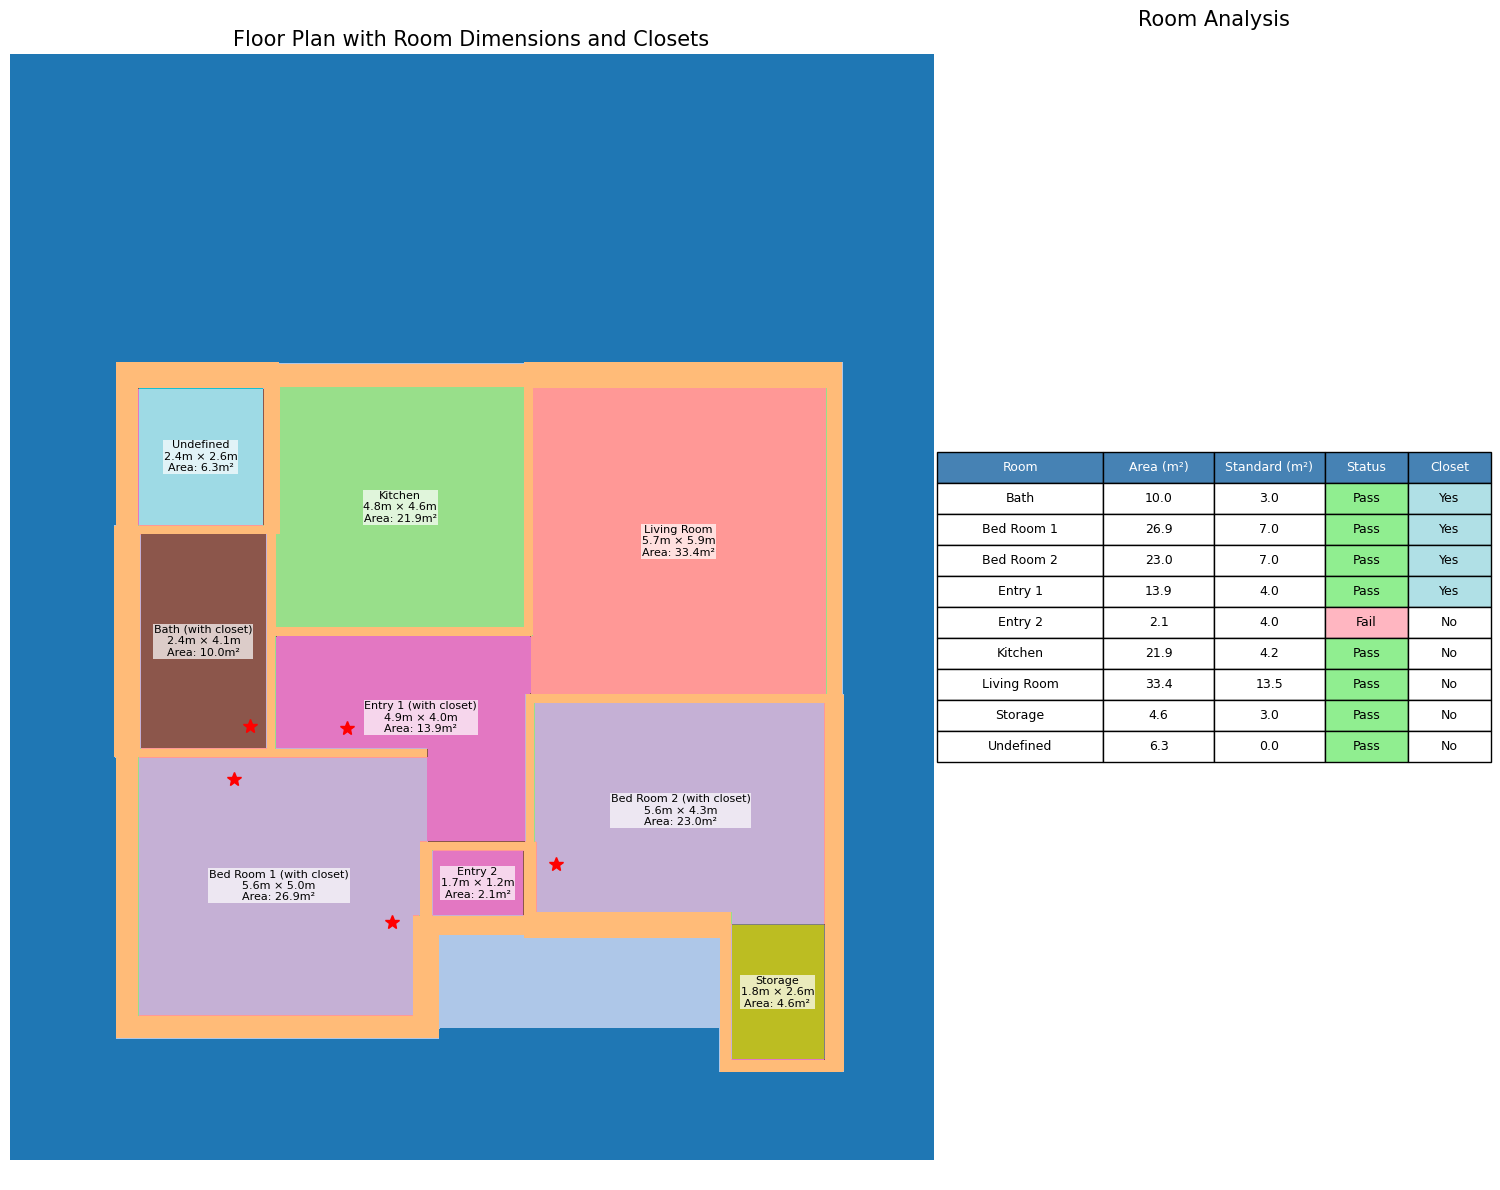

In [ ]:
fig = visualize_enhanced_floorplan(
    polygon_results['pol_room_seg'],
    polygon_results['pol_icon_seg'],
    room_classes,
    icon_classes,
    door_scale
)

In [ ]:
def analyze_bedrooms_with_closets(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str],
    scale_meters_per_pixel: float = None
) -> Tuple[Dict, List]:
    """
    Analyzes bedrooms with specific focus on closet presence and area metrics.
    """
    # First get the bedroom-closet mapping
    rooms_with_closets = find_rooms_with_closets(
        pol_room_seg, pol_icon_seg, room_classes, icon_classes
    )

    # Calculate scale if not provided
    if scale_meters_per_pixel is None:
        room_areas_px = []
        for room_idx in range(len(room_classes)):
            room_mask = (pol_room_seg == room_idx)
            if np.any(room_mask):
                polygon = get_polygon_from_mask(room_mask)
                if polygon:
                    room_areas_px.append(polygon.area)

        if room_areas_px:
            avg_room_area_px = np.median(room_areas_px)
            avg_room_area_m = 14
            scale_meters_per_pixel = np.sqrt(avg_room_area_m / avg_room_area_px)
        else:
            scale_meters_per_pixel = 0.05

    # Get bedroom indices
    bedroom_indices = [i for i, name in enumerate(room_classes)
                      if 'bed' in name.lower() or 'bedroom' in name.lower()]

    # Calculate metrics for bedrooms
    bedroom_metrics = []

    for bedroom_idx in bedroom_indices:
        room_mask = (pol_room_seg == bedroom_idx)
        labeled_array, num_features = ndimage.label(room_mask)

        # Process each instance of this bedroom
        bedroom_instances = []
        for feature_idx in range(1, num_features + 1):
            component = (labeled_array == feature_idx)
            polygon = get_polygon_from_mask(component)

            if polygon:
                area = polygon.area * (scale_meters_per_pixel ** 2)
                bounds = polygon.bounds
                width = (bounds[2] - bounds[0]) * scale_meters_per_pixel
                height = (bounds[3] - bounds[1]) * scale_meters_per_pixel
                centroid = polygon.centroid

                # Get closet information
                closet_locations = rooms_with_closets.get(bedroom_idx, [])

                standard_area = get_standard_area('Bed Room')
                status = 'Pass' if area >= standard_area else 'Fail'

                metrics = {
                    'room_class': room_classes[bedroom_idx],
                    'area': area,
                    'width': width,
                    'height': height,
                    'standard_area': standard_area,
                    'status': status,
                    'centroid': centroid,
                    'has_closet': bool(closet_locations),
                    'closet_locations': closet_locations,
                    'component': component
                }
                bedroom_instances.append(metrics)

        # Sort instances by area and add instance numbers
        if bedroom_instances:
            bedroom_instances.sort(key=lambda x: x['area'], reverse=True)
            for idx, bedroom in enumerate(bedroom_instances, 1):
                bedroom['instance'] = idx
                bedroom_metrics.append(bedroom)

    return bedroom_metrics

def visualize_bedroom_analysis(
    pol_room_seg: np.ndarray,
    pol_icon_seg: np.ndarray,
    room_classes: List[str],
    icon_classes: List[str],
    scale_meters_per_pixel: float = None
) -> None:
    """
    Creates visualization focusing on bedroom analysis with closet information.
    """
    bedroom_metrics = analyze_bedrooms_with_closets(
        pol_room_seg, pol_icon_seg, room_classes, icon_classes, scale_meters_per_pixel
    )

    # Create figure
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

    # Floorplan subplot
    ax_plan = fig.add_subplot(gs[0])
    ax_plan.set_title('Bedroom Analysis with Closets', fontsize=15)
    ax_plan.axis('off')

    # Display full segmentation map with bedrooms highlighted
    cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))
    custom_cmap = plt.cm.colors.ListedColormap(cmap)
    rseg = ax_plan.imshow(pol_room_seg, cmap=custom_cmap, alpha=0.3)

    # Highlight bedrooms
    for metrics in bedroom_metrics:
        # Show bedroom area
        bedroom_mask = metrics['component']
        ax_plan.imshow(np.ma.masked_where(~bedroom_mask, bedroom_mask),
                      cmap='Blues', alpha=0.7)

        # Add labels
        closet_info = " (with closet)" if metrics['has_closet'] else " (no closet)"
        room_label = (f"{metrics['room_class']} {metrics['instance']}"
                     if len([r for r in bedroom_metrics if r['room_class'] == metrics['room_class']]) > 1
                     else metrics['room_class'])

        centroid = metrics['centroid']
        plt.text(centroid.x, centroid.y,
                f"{room_label}{closet_info}\n"
                f"{metrics['width']:.1f}m × {metrics['height']:.1f}m\n"
                f"Area: {metrics['area']:.1f}m²",
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

        # Mark closet locations
        if metrics['has_closet']:
            for cx, cy in metrics['closet_locations']:
                plt.plot(cx, cy, 'r*', markersize=10)

    # Analysis table
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    ax_table.set_title('Bedroom Analysis', fontsize=15)

    # Prepare table data
    table_data = [['Bedroom', 'Area (m²)', 'Status', 'Closet']]

    for metrics in bedroom_metrics:
        room_name = (f"{metrics['room_class']} {metrics['instance']}"
                    if len([r for r in bedroom_metrics if r['room_class'] == metrics['room_class']]) > 1
                    else metrics['room_class'])
        table_data.append([
            room_name,
            f"{metrics['area']:.1f}",
            metrics['status'],
            'Yes' if metrics['has_closet'] else 'No'
        ])

    # Create and style table
    table = ax_table.table(cellText=table_data,
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.4, 0.2, 0.2, 0.2])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Style cells
    for idx in range(1, len(table_data)):
        # Color status cell
        status = table_data[idx][2]
        cell = table._cells[(idx, 2)]
        if status == 'Pass':
            cell.set_facecolor('#90EE90')
        else:
            cell.set_facecolor('#FFB6C1')

        # Color closet cell
        has_closet = table_data[idx][3] == 'Yes'
        cell = table._cells[(idx, 3)]
        if has_closet:
            cell.set_facecolor('#B0E0E6')

    # Style header row
    for i in range(4):
        table._cells[(0, i)].set_facecolor('#4682B4')
        table._cells[(0, i)].set_text_props(color='white')

    plt.tight_layout()
    return fig

# Example usage:
"""
fig = visualize_bedroom_analysis(
    pol_room_seg,
    pol_icon_seg,
    room_classes,
    icon_classes
)
"""

'\nfig = visualize_bedroom_analysis(\n    pol_room_seg,\n    pol_icon_seg,\n    room_classes,\n    icon_classes\n)\n'

<ipython-input-31-0d5e180bc136>:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(room_classes)))


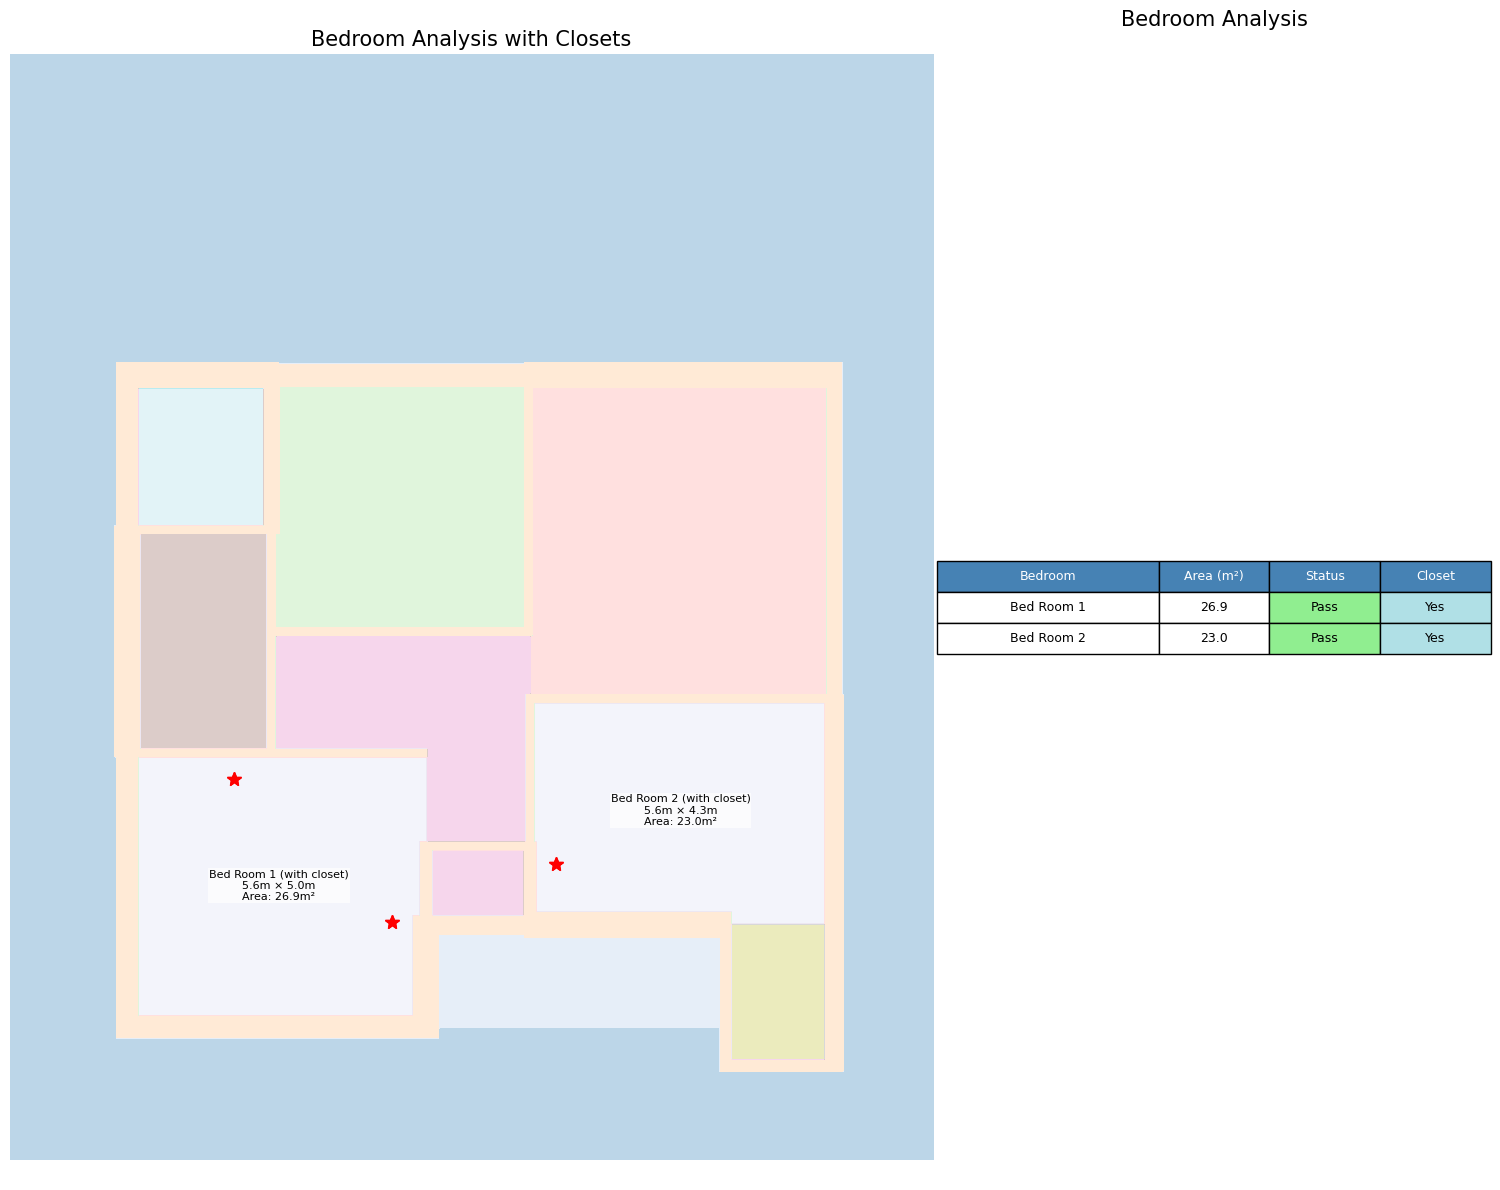

In [ ]:
fig = visualize_bedroom_analysis(
    polygon_results['pol_room_seg'],
    polygon_results['pol_icon_seg'],
    room_classes,
    icon_classes,
    door_scale
)